# Collaborative Filter

The data used in this code is MovieLens 20M Dataset updated 10/2016. You can download data [here](http://files.grouplens.org/datasets/movielens/ml-20m.zip).

In [34]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import KFold
import time
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt


import warnings
#from sklearn.exceptions import DataConversionWarning 
#warnings.filterwarnings(action='ignore', category=DataConversionWarning)


#Change path to run
ratings = pd.read_csv('MovieLens/ml-20m/ratings.csv',sep=',',usecols=range(3))
movies = pd.read_csv('MovieLens/ml-20m/movies.csv',sep=',')
ratings = pd.merge(movies, ratings)
ratings=ratings[0:1000000]
ratings.head(10)

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6,5.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,4.0
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10,4.0
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.5
5,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,12,4.0
6,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,4.0
7,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,14,4.5
8,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,16,3.0
9,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,5.0


In [4]:
ratings_shuffle = ratings.sample(frac=1)

In [5]:
ratings_shuffle.head(10)

,userId,movieId,rating
694429,4600,4533,3.5
833084,5544,1206,5.0
743795,4967,1233,3.5
213787,1470,2750,3.0
265889,1838,1882,3.5
895713,6002,6383,4.0
782508,5209,3702,4.0
819519,5466,2797,3.5
242343,1677,2858,3.0
297213,2035,45517,3.0


In [6]:
# Create utility matrix
df_movie_features = ratings.pivot(index='movieId',columns='userId',values='rating').fillna(0)
M=df_movie_features.shape[0]
U=df_movie_features.shape[1]
df_movie_features.head()

userId,1,2,3,4,5,6,7,8,9,10,...,6734,6735,6736,6737,6738,6739,6740,6741,6742,6743
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,5.0,0.0,4.0,0.0,4.0,...,0.5,4.0,4.0,3.0,0.0,4.0,0.0,4.0,0.0,4.0
2,3.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,0.0,4.0,0.0,0.0,0.0,3.0,3.0,5.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
df_movie_features.shape

(13950, 6743)

In [4]:
mat_movie_features = csr_matrix(df_movie_features.values)

In [8]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)
model_knn.fit(df_movie_features.values)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=10, p=2, radius=1.0)

In [9]:
distance,indice=model_knn.kneighbors(df_movie_features.values,n_neighbors=10)

In [10]:
S = np.zeros((M,M))
for i in range(0,M):
    S[i,indice[i,]]=distance[i,]
    S[i,i]=1
#print(S[0,:].sum())
print(S.shape)

(13950, 13950)


In [11]:
tmp=abs(S).sum(axis=1)
df_pred=np.dot(S,df_movie_features)/tmp[:,None]

In [9]:
rmse_knn=np.sqrt(np.nanmean(np.square(df_movie_features[df_movie_features!=0]-df_pred)))
rmse_knn

1.6844142906795845

In [10]:
mae=np.nanmean(df_movie_features[df_movie_features!=0].abs()-np.abs(df_pred))
mae

1.2960139608381611

# Cross Validation

## Item-Based CF

In [12]:
def data_process(data,item_flag):
    if item_flag: # item-based CF
        df_processed = data.pivot(index='movieId',columns='userId',values='rating').fillna(0)
    else:
        df_processed = data.pivot(index='userId',columns='movieId',values='rating').fillna(0)
    return df_processed,df_processed.shape[0]
def data_extend(data,target_data):
    df_extended=pd.DataFrame(np.zeros((target_data.shape[0],target_data.shape[1])),index=target_data.index.unique(),
                   columns=target_data.columns.unique())
    df_extended.loc[data.index,data.columns]=data
    return df_extended   

In [13]:
# cross validation
def CV(model,nneigh,nfolds,data,verbose,item_flag):
    kf=KFold(n_splits=nfolds)
    rmse_train=[]
    mae_train=[]
    rmse_test=[]
    mae_test=[]
    for j, (train_index, test_index) in enumerate(kf.split(data)):
        if not verbose:
            print("----Now processing fold: %d----" % (j+1))
        start = time.time()
        train, test = data.iloc[train_index], data.iloc[test_index]
        df_movie_features,M=data_process(data,item_flag)
        train,M_train = data_process(train,item_flag)
        test,M_test = data_process(test,item_flag)
        
        train_extend=data_extend(train,df_movie_features)
        test_extend=data_extend(test,df_movie_features)
        model.fit(train.values)
        
        #train model
        distance,indice=model.kneighbors(train.values,n_neighbors=nneigh)
        S = pd.DataFrame(np.eye(M),index=df_movie_features.index.unique(),columns=df_movie_features.index.unique())
        for i in range(0,M_train):
            S.loc[train.index[i],train.index[indice[i,]]]=1-distance[i,]

        #predict 
        tmp=abs(S).sum(axis=1)
        pred=np.dot(S,train_extend)/tmp[:,None]
        #print(np.sqrt(np.nanmean(np.square(train_extend[train_extend!=0]-pred_train))))
        #print(np.nanmean(train_extend[train_extend!=0].abs()-np.abs(pred_train)))      
        
        #evaluate
        #train
        rmse_train.append(np.sqrt(np.nanmean(np.square(train_extend[train_extend!=0]-pred))))
        mae_train.append(np.nanmean(train_extend[train_extend!=0].abs()-np.abs(pred))) 
        
        #test

        tmp=abs(S).sum(axis=1)
       # pred_test=np.dot(S,test_extend)/tmp[:,None]
        rmse_test.append(np.sqrt(np.nanmean(np.square(test_extend[test_extend!=0]-pred))))
        mae_test.append(np.nanmean(test_extend[test_extend!=0].abs()-np.abs(pred)))      
        #print(np.sqrt(np.nanmean(np.square(test_extend[test_extend!=0]-pred_test))))
        #print(np.nanmean(test_extend[test_extend!=0].abs()-np.abs(pred_test)))      
        
        if not verbose:
            #print("----This fold: %d is finished in %.4f----" %( i+1, (time.time()-start)))
            print("Fold %d cost time %.4f, train RMSE: %.4f, calibration RMSE: %.4f, train MAE: %.4f, calibration MAE: %.4f" % \
                  (j+1, time.time()-start, rmse_train[j], rmse_test[j], mae_train[j], mae_test[j]))
    return (np.mean(rmse_test, axis = 0),np.mean(mae_test, axis = 0),np.mean(rmse_train, axis = 0),np.mean(mae_train, axis = 0))

In [15]:
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)
knn_cv_item = CV(model_knn,nneigh=10,nfolds=3,data=ratings_shuffle,verbose=0,item_flag=1)

----Now processing fold: 1----
Fold 1 cost time 252.6724, train RMSE: 1.9104, calibration RMSE: 2.9761, train MAE: 1.6863, calibration MAE: 2.7550
----Now processing fold: 2----
Fold 2 cost time 234.7821, train RMSE: 1.9114, calibration RMSE: 2.9785, train MAE: 1.6892, calibration MAE: 2.7577
----Now processing fold: 3----
Fold 3 cost time 239.2081, train RMSE: 1.9104, calibration RMSE: 2.9779, train MAE: 1.6869, calibration MAE: 2.7565


In [16]:
print("average RMSE: {:.4f}, average MAE: {:.4f}".format(knn_cv_item[0],knn_cv_item[1]))

average RMSE: 2.9775, average MAE: 2.7564


## User-Based CF

In [17]:
knn_cv_user = CV(model_knn,nneigh=10,nfolds=3,data=ratings_shuffle,verbose=0,item_flag=0)

----Now processing fold: 1----
Fold 1 cost time 148.9041, train RMSE: 1.9275, calibration RMSE: 3.0415, train MAE: 1.6987, calibration MAE: 2.8227
----Now processing fold: 2----
Fold 2 cost time 140.5502, train RMSE: 1.9319, calibration RMSE: 3.0470, train MAE: 1.7022, calibration MAE: 2.8279
----Now processing fold: 3----
Fold 3 cost time 155.0459, train RMSE: 1.9257, calibration RMSE: 3.0403, train MAE: 1.6948, calibration MAE: 2.8195


In [18]:
print("average RMSE: {:.4f}, average MAE: {:.4f}".format(knn_cv_user[0],knn_cv_user[1]))

average RMSE: 3.0429, average MAE: 2.8234


# Grid Search

## User-Based

In [20]:
## Grid Search
Item_flag =[0,1]
Metric = ['cosine','jaccard','correlation']
Nneighbor = np.arange(5,55,5)
param_grid = {'Item_flag':Item_flag, 'Metric': Metric,'Nneighbor':Nneighbor}
param_grid = list(ParameterGrid(param_grid))

scores_f = []
best_scores_rmse= float('inf')
best_scores_mae = float('inf')

start = time.time()
for j, param_set in enumerate(param_grid):
    print('--------------Start Parameter Set:',param_set.get('Nneighbor'),
          param_set.get('Metric'),param_set.get('Item_flag'),'----------------')
    knn = NearestNeighbors(metric=param_set.get('Metric'), algorithm='brute', 
                                 n_neighbors=param_set.get('Nneighbor'), n_jobs=-1)
    knn_cv = CV(knn,nneigh=param_set.get('Nneighbor'),nfolds=3,data=ratings_shuffle,
                verbose=0,item_flag=param_set.get('Item_flag'))
    scores_f.append(knn_cv)
    if best_scores_rmse > knn_cv[0]:
        best_scores_rmse = knn_cv[0]
        best_param_rmse = param_set
        
    if best_scores_mae > knn_cv[1]:
        best_scores_mae = knn_cv[1]
        best_param_mae = param_set
print("best parameter set is %s, with RMSE is %.4f" % (best_param_rmse, best_scores_rmse))
print("best parameter set is %s, with MAE is %.4f" % (best_param_mae, best_scores_mae))
print("finsied in %s seconds" %(time.time()-start))

--------------Start Parameter Set: 5 cosine 0 ----------------
----Now processing fold: 1----
Fold 1 cost time 153.3337, train RMSE: 1.4898, calibration RMSE: 3.1794, train MAE: 1.2694, calibration MAE: 2.9713
----Now processing fold: 2----
Fold 2 cost time 148.9096, train RMSE: 1.4922, calibration RMSE: 3.1838, train MAE: 1.2713, calibration MAE: 2.9758
----Now processing fold: 3----
Fold 3 cost time 142.0510, train RMSE: 1.4879, calibration RMSE: 3.1806, train MAE: 1.2667, calibration MAE: 2.9716
--------------Start Parameter Set: 10 cosine 0 ----------------
----Now processing fold: 1----
Fold 1 cost time 136.9577, train RMSE: 1.9275, calibration RMSE: 3.0415, train MAE: 1.6987, calibration MAE: 2.8227
----Now processing fold: 2----
Fold 2 cost time 142.8349, train RMSE: 1.9319, calibration RMSE: 3.0470, train MAE: 1.7022, calibration MAE: 2.8279
----Now processing fold: 3----
Fold 3 cost time 143.7733, train RMSE: 1.9257, calibration RMSE: 3.0403, train MAE: 1.6948, calibration MAE

/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 1 cost time 571.2442, train RMSE: 1.1318, calibration RMSE: 3.3039, train MAE: 0.9552, calibration MAE: 3.1162
----Now processing fold: 2----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 2 cost time 576.9026, train RMSE: 1.1332, calibration RMSE: 3.3063, train MAE: 0.9558, calibration MAE: 3.1180
----Now processing fold: 3----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 3 cost time 573.0186, train RMSE: 1.1315, calibration RMSE: 3.3053, train MAE: 0.9539, calibration MAE: 3.1162
--------------Start Parameter Set: 10 jaccard 0 ----------------
----Now processing fold: 1----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 1 cost time 570.0820, train RMSE: 1.6143, calibration RMSE: 3.1575, train MAE: 1.4122, calibration MAE: 2.9532
----Now processing fold: 2----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 2 cost time 570.3416, train RMSE: 1.6166, calibration RMSE: 3.1623, train MAE: 1.4148, calibration MAE: 2.9582
----Now processing fold: 3----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 3 cost time 573.4667, train RMSE: 1.6142, calibration RMSE: 3.1575, train MAE: 1.4112, calibration MAE: 2.9516
--------------Start Parameter Set: 15 jaccard 0 ----------------
----Now processing fold: 1----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 1 cost time 574.1306, train RMSE: 1.8654, calibration RMSE: 3.0923, train MAE: 1.6518, calibration MAE: 2.8801
----Now processing fold: 2----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 2 cost time 574.4607, train RMSE: 1.8685, calibration RMSE: 3.0969, train MAE: 1.6550, calibration MAE: 2.8851
----Now processing fold: 3----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 3 cost time 577.4622, train RMSE: 1.8656, calibration RMSE: 3.0921, train MAE: 1.6511, calibration MAE: 2.8784
--------------Start Parameter Set: 20 jaccard 0 ----------------
----Now processing fold: 1----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 1 cost time 570.9969, train RMSE: 2.0235, calibration RMSE: 3.0560, train MAE: 1.8031, calibration MAE: 2.8395
----Now processing fold: 2----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 2 cost time 575.3856, train RMSE: 2.0265, calibration RMSE: 3.0600, train MAE: 1.8062, calibration MAE: 2.8439
----Now processing fold: 3----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 3 cost time 571.0054, train RMSE: 2.0239, calibration RMSE: 3.0565, train MAE: 1.8028, calibration MAE: 2.8384
--------------Start Parameter Set: 25 jaccard 0 ----------------
----Now processing fold: 1----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 1 cost time 572.8741, train RMSE: 2.1343, calibration RMSE: 3.0339, train MAE: 1.9097, calibration MAE: 2.8147
----Now processing fold: 2----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 2 cost time 570.3924, train RMSE: 2.1363, calibration RMSE: 3.0369, train MAE: 1.9118, calibration MAE: 2.8181
----Now processing fold: 3----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 3 cost time 571.8813, train RMSE: 2.1338, calibration RMSE: 3.0338, train MAE: 1.9085, calibration MAE: 2.8129
--------------Start Parameter Set: 30 jaccard 0 ----------------
----Now processing fold: 1----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 1 cost time 567.1407, train RMSE: 2.2163, calibration RMSE: 3.0187, train MAE: 1.9890, calibration MAE: 2.7980
----Now processing fold: 2----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 2 cost time 570.7211, train RMSE: 2.2181, calibration RMSE: 3.0217, train MAE: 1.9907, calibration MAE: 2.8013
----Now processing fold: 3----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 3 cost time 574.2999, train RMSE: 2.2164, calibration RMSE: 3.0190, train MAE: 1.9881, calibration MAE: 2.7966
--------------Start Parameter Set: 35 jaccard 0 ----------------
----Now processing fold: 1----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 1 cost time 576.2377, train RMSE: 2.2810, calibration RMSE: 3.0086, train MAE: 2.0518, calibration MAE: 2.7870
----Now processing fold: 2----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 2 cost time 574.6848, train RMSE: 2.2823, calibration RMSE: 3.0112, train MAE: 2.0529, calibration MAE: 2.7897
----Now processing fold: 3----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 3 cost time 574.2639, train RMSE: 2.2807, calibration RMSE: 3.0088, train MAE: 2.0505, calibration MAE: 2.7854
--------------Start Parameter Set: 40 jaccard 0 ----------------
----Now processing fold: 1----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 1 cost time 575.9053, train RMSE: 2.3328, calibration RMSE: 3.0013, train MAE: 2.1023, calibration MAE: 2.7789
----Now processing fold: 2----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 2 cost time 578.4124, train RMSE: 2.3343, calibration RMSE: 3.0039, train MAE: 2.1035, calibration MAE: 2.7816
----Now processing fold: 3----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 3 cost time 576.9594, train RMSE: 2.3324, calibration RMSE: 3.0015, train MAE: 2.1009, calibration MAE: 2.7775
--------------Start Parameter Set: 45 jaccard 0 ----------------
----Now processing fold: 1----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 1 cost time 573.1233, train RMSE: 2.3758, calibration RMSE: 2.9959, train MAE: 2.1443, calibration MAE: 2.7732
----Now processing fold: 2----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 2 cost time 599.2534, train RMSE: 2.3771, calibration RMSE: 2.9983, train MAE: 2.1454, calibration MAE: 2.7756
----Now processing fold: 3----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 3 cost time 610.6276, train RMSE: 2.3753, calibration RMSE: 2.9962, train MAE: 2.1428, calibration MAE: 2.7718
--------------Start Parameter Set: 50 jaccard 0 ----------------
----Now processing fold: 1----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 1 cost time 575.3314, train RMSE: 2.4121, calibration RMSE: 2.9919, train MAE: 2.1799, calibration MAE: 2.7690
----Now processing fold: 2----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 2 cost time 578.1831, train RMSE: 2.4135, calibration RMSE: 2.9942, train MAE: 2.1811, calibration MAE: 2.7713
----Now processing fold: 3----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 3 cost time 579.8821, train RMSE: 2.4114, calibration RMSE: 2.9921, train MAE: 2.1782, calibration MAE: 2.7674
--------------Start Parameter Set: 5 correlation 0 ----------------
----Now processing fold: 1----
Fold 1 cost time 517.7502, train RMSE: 1.4828, calibration RMSE: 3.2188, train MAE: 1.2735, calibration MAE: 3.0181
----Now processing fold: 2----
Fold 2 cost time 528.0006, train RMSE: 1.4864, calibration RMSE: 3.2240, train MAE: 1.2769, calibration MAE: 3.0236
----Now processing fold: 3----
Fold 3 cost time 517.8888, train RMSE: 1.4811, calibration RMSE: 3.2195, train MAE: 1.2716, calibration MAE: 3.0179
--------------Start Parameter Set: 10 correlation 0 ----------------
----Now processing fold: 1----
Fold 1 cost time 530.4381, train RMSE: 1.9352, calibration RMSE: 3.0868, train MAE: 1.7153, calibration MAE: 2.8755
----Now processing fold: 2----
Fold 2 cost time 542.5564, train RMSE: 1.9393, calibration RMSE: 3.0923, train MAE: 1.7191, calibration MAE: 2.8812
----Now proc

KeyboardInterrupt: 

In [21]:
print("best parameter set is %s, with RMSE is %.4f" % (best_param_rmse, best_scores_rmse))
print("best parameter set is %s, with MAE is %.4f" % (best_param_mae, best_scores_mae))

best parameter set is {'Item_flag': 0, 'Metric': 'cosine', 'Nneighbor': 50}, with RMSE is 2.9247
best parameter set is {'Item_flag': 0, 'Metric': 'cosine', 'Nneighbor': 50}, with MAE is 2.7027


In [22]:
rmse_test=[]
mae_test=[]
rmse_train=[]
mae_train=[]

for i in range(len(scores_f)):
    rmse_test.append(scores_f[i][0])
    mae_test.append(scores_f[i][1])
    rmse_train.append(scores_f[i][2])
    mae_train.append(scores_f[i][3])

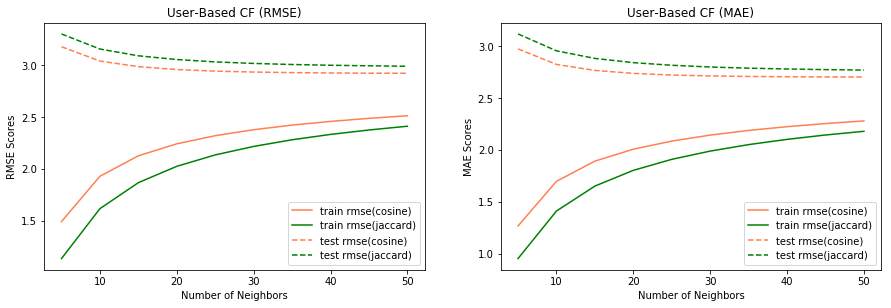

In [32]:
plt.figure(figsize=(15,10))
plt.subplot(221)
plt.plot(Nneighbor,rmse_train[0:len(Nneighbor)],label='train rmse(cosine)',color='coral', linestyle='-')
plt.plot(Nneighbor,rmse_train[len(Nneighbor):2*len(Nneighbor)],label='train rmse(jaccard)',color='green', linestyle='-')
#plt.plot(Nneighbor,rmse_train[2*len(Nneighbor):3*len(Nneighbor)],label='train rmse(correlation)',color='blue', linestyle='-')
plt.plot(Nneighbor,rmse_test[0:len(Nneighbor)],label='test rmse(cosine)',color='coral', linestyle='--')
plt.plot(Nneighbor,rmse_test[len(Nneighbor):2*len(Nneighbor)],label='test rmse(jaccard)',color='green', linestyle='--')
#plt.plot(Nneighbor,rmse_test[2*len(Nneighbor):3*len(Nneighbor)],label='test rmse(correlation)',color='blue', linestyle='--')
plt.title('User-Based CF (RMSE)')
plt.xlabel('Number of Neighbors')
plt.ylabel('RMSE Scores')
plt.legend()

#plt.subplot(222)
#plt.plot(Nneighbor,rmse_train[3*len(Nneighbor):4*len(Nneighbor)],label='train rmse(cosine)',color='coral', linestyle='-')
#plt.plot(Nneighbor,rmse_train[4*len(Nneighbor):5*len(Nneighbor)],label='train rmse(jaccard)',color='green', linestyle='-')
#plt.plot(Nneighbor,rmse_train[5*len(Nneighbor):6*len(Nneighbor)],label='train rmse(correlation)',color='blue', linestyle='-')
#plt.plot(Nneighbor,rmse_test[3*len(Nneighbor):4*len(Nneighbor)],label='test rmse(cosine)',color='coral', linestyle='--')
#plt.plot(Nneighbor,rmse_test[4*len(Nneighbor):5*len(Nneighbor)],label='test rmse(jaccard)',color='green', linestyle='--')
#plt.plot(Nneighbor,rmse_test[5*len(Nneighbor):6*len(Nneighbor)],label='test rmse(correlation)',color='blue', linestyle='--')
#plt.title('Item-Based CF (RMSE)')
#plt.xlabel('Number of Neighbors')
#plt.ylabel('RMSE Scores')
#plt.legend()

plt.subplot(222)
plt.plot(Nneighbor,mae_train[0:len(Nneighbor)],label='train rmse(cosine)',color='coral', linestyle='-')
plt.plot(Nneighbor,mae_train[len(Nneighbor):2*len(Nneighbor)],label='train rmse(jaccard)',color='green', linestyle='-')
#plt.plot(Nneighbor,mae_train[2*len(Nneighbor):3*len(Nneighbor)],label='train rmse(correlation)',color='blue', linestyle='-')
plt.plot(Nneighbor,mae_test[0:len(Nneighbor)],label='test rmse(cosine)',color='coral', linestyle='--')
plt.plot(Nneighbor,mae_test[len(Nneighbor):2*len(Nneighbor)],label='test rmse(jaccard)',color='green', linestyle='--')
#plt.plot(Nneighbor,mae_test[2*len(Nneighbor):3*len(Nneighbor)],label='test rmse(correlation)',color='blue', linestyle='--')
plt.title('User-Based CF (MAE)')
plt.xlabel('Number of Neighbors')
plt.ylabel('MAE Scores')
plt.legend()

#plt.subplot(224)
#plt.plot(Nneighbor,mae_train[3*len(Nneighbor):4*len(Nneighbor)],label='train rmse(cosine)',color='coral', linestyle='-')
#plt.plot(Nneighbor,mae_train[4*len(Nneighbor):5*len(Nneighbor)],label='train rmse(jaccard)',color='green', linestyle='-')
#plt.plot(Nneighbor,mae_train[5*len(Nneighbor):6*len(Nneighbor)],label='train rmse(correlation)',color='blue', linestyle='-')
#plt.plot(Nneighbor,mae_test[3*len(Nneighbor):4*len(Nneighbor)],label='test rmse(cosine)',color='coral', linestyle='--')
#plt.plot(Nneighbor,mae_test[4*len(Nneighbor):5*len(Nneighbor)],label='test rmse(jaccard)',color='green', linestyle='--')
#plt.plot(Nneighbor,mae_test[5*len(Nneighbor):6*len(Nneighbor)],label='test rmse(correlation)',color='blue', linestyle='--')
#plt.title('Item-Based CF (MAE)')
#plt.xlabel('Number of Neighbors')
#plt.ylabel('MAE Scores')
#plt.legend()

plt.show()

In [40]:
start=time.time()
model_knn_user = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=32, n_jobs=-1)
knn_cv_user = CV(model_knn_user,nneigh=32,nfolds=5,data=ratings_shuffle,verbose=0,item_flag=0)
print("training time:",time.time()-start)

----Now processing fold: 1----
Fold 1 cost time 186.6627, train RMSE: 2.2881, calibration RMSE: 2.7409, train MAE: 1.9956, calibration MAE: 2.4687
----Now processing fold: 2----
Fold 2 cost time 171.3853, train RMSE: 2.2867, calibration RMSE: 2.7409, train MAE: 1.9947, calibration MAE: 2.4691
----Now processing fold: 3----
Fold 3 cost time 180.0010, train RMSE: 2.2887, calibration RMSE: 2.7456, train MAE: 1.9961, calibration MAE: 2.4737
----Now processing fold: 4----
Fold 4 cost time 205.0086, train RMSE: 2.2885, calibration RMSE: 2.7421, train MAE: 1.9979, calibration MAE: 2.4700
----Now processing fold: 5----
Fold 5 cost time 191.6917, train RMSE: 2.2881, calibration RMSE: 2.7427, train MAE: 1.9952, calibration MAE: 2.4693
training time: 936.7423989772797


In [42]:
print("average RMSE: {:.4f}, average MAE: {:.4f}".format(knn_cv_user[0],knn_cv_user[1]))

average RMSE: 2.7424, average MAE: 2.4702


## Item-based

In [44]:
start = time.time()
model_knn_item = NearestNeighbors(metric='jaccard', algorithm='brute', n_neighbors=29, n_jobs=-1)
knn_cv_item = CV(model_knn_item,nneigh=29,nfolds=5,data=ratings_shuffle,verbose=0,item_flag=1)
print("training time:",time.time()-start)

----Now processing fold: 1----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 1 cost time 1164.2705, train RMSE: 2.1216, calibration RMSE: 2.8026, train MAE: 1.8641, calibration MAE: 2.5521
----Now processing fold: 2----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 2 cost time 1086.3063, train RMSE: 2.1225, calibration RMSE: 2.8058, train MAE: 1.8649, calibration MAE: 2.5559
----Now processing fold: 3----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 3 cost time 1173.5694, train RMSE: 2.1226, calibration RMSE: 2.8094, train MAE: 1.8651, calibration MAE: 2.5589
----Now processing fold: 4----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 4 cost time 1138.9672, train RMSE: 2.1227, calibration RMSE: 2.8059, train MAE: 1.8658, calibration MAE: 2.5553
----Now processing fold: 5----


/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/Users/monica/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype float64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Fold 5 cost time 1104.3052, train RMSE: 2.1219, calibration RMSE: 2.8066, train MAE: 1.8640, calibration MAE: 2.5557
training time: 5668.63702082634


In [45]:
print("average RMSE: {:.4f}, average MAE: {:.4f}".format(knn_cv_item[0],knn_cv_item[1]))

average RMSE: 2.8061, average MAE: 2.5556
